Investigate the trend in data availability

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")

In [10]:
# open the data for each glacier, format into a single df
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>1: continue
    
    rgi_id = row['rgi_id']
    
    if rgi_id != 'RGI2000-v7.0-G-15-14683': continue
    
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list
    path_open = os.path.join(folder_glaciers, rgi_id, 'Clouds', 'cloud_comparison_info.csv')
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)


# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region']: continue
    df_all[c] = df_all[c].astype(float)
print("All done!")

All done!


In [11]:
df_g

,0,1988,12.0,3.612572161642078
0,1,1989,8.000000,4.389566
1,2,1990,11.000000,4.966218
2,3,1991,11.000000,2.653624
3,4,1992,11.000000,5.944409
4,5,1993,10.000000,3.491554
5,6,1994,15.000000,4.333333
6,7,1995,9.000000,6.228565
7,8,1996,11.000000,3.756468
8,9,1997,13.000000,3.096857
9,10,1998,14.000000,6.346376


In [8]:
# lets add column that calculates total obs across all years
year_range = range(1988,1999)
cols_obs = [ f"obs_{y}" for y in year_range ]
cols_qa = [ f"qa_cloud_{y}" for y in year_range ]
cols_acca = [ f"acca_cloud_{y}" for y in year_range ]
cols_accaqa = [ f"accaqa_cloud_{y}" for y in year_range ]

df_all['obs_sum'] = df_all[cols_obs].sum(axis=1)
df_all['qa_sum'] = df_all[cols_qa].sum(axis=1)
df_all['acca_sum'] = df_all[cols_acca].sum(axis=1)
df_all['accaqa_sum'] = df_all[cols_accaqa].sum(axis=1)

Text(0, 0.5, 'ACCAQA cloud observations')

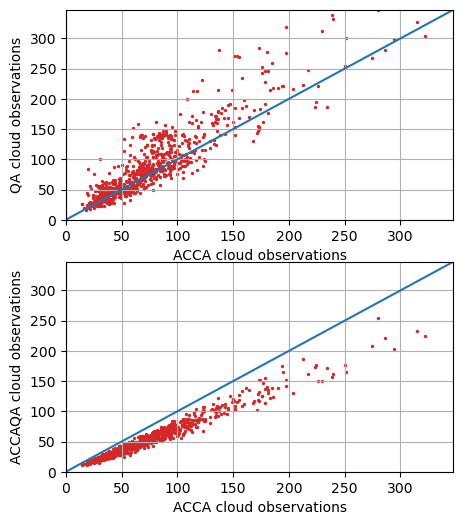

In [9]:
n_max = max(np.nanmax(df_all['acca_sum']),np.nanmax(df_all['qa_sum']) )

# start figure
fig, axs = plt.subplots(2,1, figsize=(5,6))

axs[0].scatter(df_all['acca_sum'], df_all['qa_sum'], s=2, c='tab:red')
axs[1].scatter(df_all['acca_sum'], df_all['accaqa_sum'], s=2, c='tab:red')

for ax in axs:
    ax.plot([0,n_max], [0,n_max])
    ax.set_xlim(0,n_max)
    ax.set_ylim(0,n_max)
    ax.grid(zorder=1)

axs[0].set_xlabel("ACCA cloud observations")
axs[0].set_ylabel("QA cloud observations")
axs[1].set_xlabel("ACCA cloud observations")
axs[1].set_ylabel("ACCAQA cloud observations")


Text(0.5, 0, 'Glacier-specific cloud cover frequency')

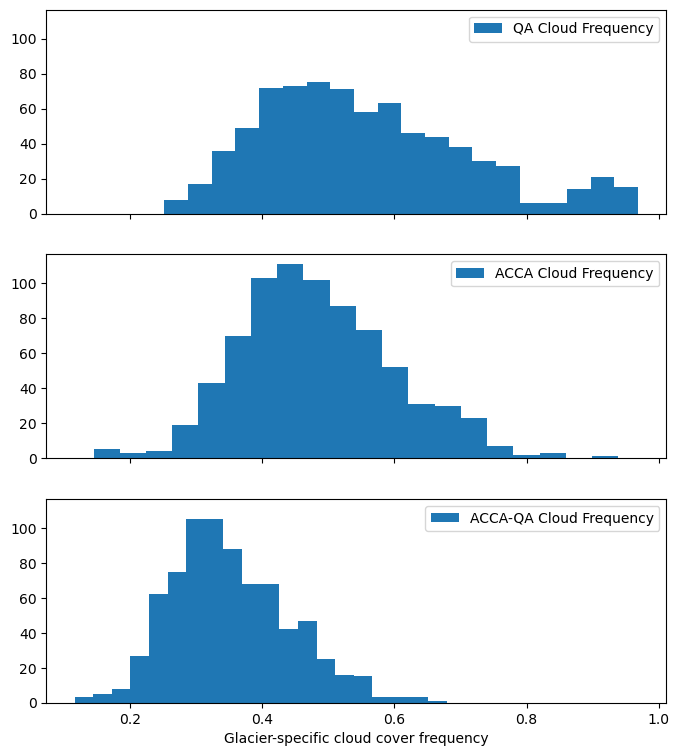

In [10]:
# histogram
fig, axs = plt.subplots(3,1, figsize=(8,9), sharex=True, sharey=True)

hist_data = df_all['qa_sum']/df_all['obs_sum']
axs[0].hist(hist_data, bins=20, label='QA Cloud Frequency')
axs[0].legend()

hist_data = df_all['acca_sum']/df_all['obs_sum']
axs[1].hist(hist_data, bins=20, label='ACCA Cloud Frequency')
axs[1].legend()

hist_data = df_all['accaqa_sum']/df_all['obs_sum']
axs[2].hist(hist_data, bins=20, label='ACCA-QA Cloud Frequency')
axs[2].legend()

axs[-1].set_xlabel('Glacier-specific cloud cover frequency')